# Sentiment Analysis using various Machine Learning Classifiers and Recurrent Neural Network.

#### Authors: Dheeraj Gadwala and Savitha Munirajaiah




# Introduction

Analyzing the sentiments of various tweets on twitter using different machine learning classification algorthms.

# Step-1: Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # for plotting 
import seaborn as sns # for ploting a graph
import re # regular expression
import nltk # natural language toolkit
from wordcloud import WordCloud 

# For data preprocessing 
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# model evaluation 
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

# Step-2: Load and Analyze the Dataset

1. Remove unnecessary columns
2. Rename the columns to meaning name
3. Taking a subset of the dataset due to processing time.

##### Note: 0 => negative sentiment; 1 => positive sentiment.

In [2]:
dfMain = pd.read_csv('training.1600000.processed.noemoticon.csv', sep = ',', encoding = 'latin-1',header=None)

In [3]:
dfMain.head(10)

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


In [4]:
# Drop unnecessary columns
dfMain = dfMain.drop(labels = [1, 2, 3, 4], axis = 'columns') 
dfMain = dfMain.rename(columns = {0:"Target", 5:"Tweet"}) # rename the columns
dfMain['Target'] = dfMain['Target'].map({0: 0, 4: 1}) # 0 => negative sentiment; 1 => positive sentiment

# Reducing the size of the dataset to 40K rows
df_pos = dfMain[dfMain['Target'] == 1].iloc[:int(20000)]
df_neg = dfMain[dfMain['Target'] == 0].iloc[:int(20000)]
df = pd.concat([df_pos, df_neg])
print(df.shape)

(40000, 2)


In [5]:
df.head() # display top 5 rows in the dataset

,Target,Tweet
800000,1,I LOVE @Health4UandPets u guys r the best!!
800001,1,im meeting up with one of my besties tonight! ...
800002,1,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800003,1,Being sick can be really cheap when it hurts t...
800004,1,@LovesBrooklyn2 he has that effect on everyone


# Step-3: Data Visualization
### Number of Positive and Negative Tweets

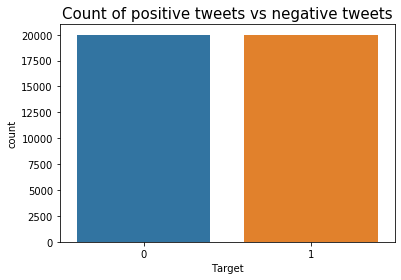

In [6]:
plt.figure(figsize=None)
sns.countplot(x = "Target", data=df)
plt.title("Count of positive tweets vs negative tweets", fontsize = 15)
plt.show()

In [7]:
# Number of positive sentiment and negative sentiment
posLen = len(df[df['Target'] == 1])
negLen = len(df[df['Target'] == 0])

print('Total Number of Tweets: {}'.format(df.shape[0]))
print('Number of Postive Tweets: {}'.format(posLen))
print('Number of Negative Tweets: {}'.format(negLen))



Total Number of Tweets: 40000
Number of Postive Tweets: 20000
Number of Negative Tweets: 20000


# Step-4: Data Pre-Processing

#### Steps Taken:
1. Remove URLs, web-addresses, and email ids.
2. Convert the tweets to lower case.
3. Tokenize the data: Remove the work
4. Remove stopwords: Dropping common words that do not add meaning or value to the classification. We obtains the list of stopwords in english from nltk.corpus library.
5. Stemming: PorterStemmer algorithm
6. Lemmentize: WordNetLemmatizer.

Stemming and Lemmatization are Text Normalization (Word Normalization) techniques used to prepare text, words, and documents for further processing. Both Stemming and Lemmatization helps us to achieve the root forms of derived words. However, Stemming is different from Lemmatization in the approach it uses to produce root forms.It strips off any suffix, prefix, infix or other internal modification such as vowel change.

Stemming is the process of reducing the word to its root form i.e. to its stem even if the stem itself is not a valid word in the language. 
PorterStemmer algorithms does not follow linguistics rather a set of 05 rules for different cases that are applied in phases to generate stems. Hence it is simple and fast. Alternatively, LancasterStemmer is an iterative algorithms with about 120 rules. It is simple but over-stemming may occur which causes the stems to be not linguisting losing its meaning altogether. Therefore, we chose PorterStemmer algorithms.

Lemmatization, unlike Stemming, reduces the words to its root word with proper meaning. The reduced words belongs to the language and the roots have a proper meaning.
We use NLTKs WordNet Database to lookup lemmas of words.

[Reference](https://www.datacamp.com/community/tutorials/stemming-lemmatization-python)

In [8]:
#fetch stop words
stopWords = set(stopwords.words('english')) 

# stemming, lemmatization, removing stop words and cleaning.
def clean_message(message):
    
    # Remove web links
    message = re.sub('\shttp\S*', ' ', message) # \S: matches non white-space characters. starting with http
    message = re.sub('\S*www\.\S*',' ', message) 
    message = re.sub('\S+\.co\.\S*', ' ', message) 
    message = re.sub('\S+\.com\s', ' ', message) # \S: matches non white-space characters. ending with .com
    
    #remove punctuation {\w: word characters-{a-zA-Z0-9_} \s-{whitespaces}}
    message = re.sub('[^\w\s]','', message)
    
    # lower case
    message = message.lower()
    
    # spaces from ends
    message = message.strip() 
    
    # split to words
    message = message.split() 
    
    # remove stop words
    message_cleaned = []
    for word in message:
        if word not in stopWords:
            message_cleaned.append(word) # add words that are not stop words.
    
    # stemming
    stemmer = PorterStemmer()
    message_stemmed = [stemmer.stem(word) for word in message_cleaned]
    
    #lemmatization
    lemmatizer = WordNetLemmatizer()
    message_lemmatized = [lemmatizer.lemmatize(word) for word in message_stemmed]
    
    return ' '.join(message_lemmatized)

In [9]:
df['Tweet'] = df['Tweet'].apply(clean_message)

In [10]:
df.head()

,Target,Tweet
800000,1,love health4uandpet u guy r best
800001,1,im meet one besti tonight cant wait girl talk
800002,1,darealsunisakim thank twitter add sunisa got m...
800003,1,sick realli cheap hurt much eat real food plu ...
800004,1,lovesbrooklyn2 effect everyon


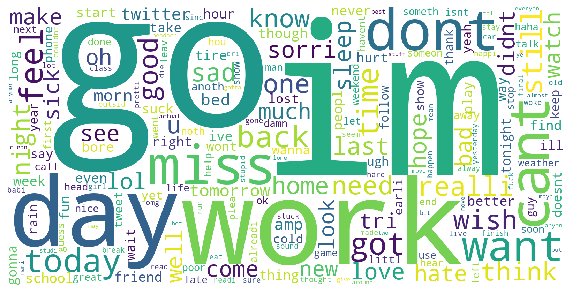

In [11]:
data_neg = df[df['Target'] == 0]['Tweet']
plt.figure(figsize = (10,10))
wc = WordCloud(
    max_words = 200 , width = 1600 , height = 800,collocations=False, background_color='white'
).generate(" ".join(data_neg))
plt.imshow(wc)
plt.axis('off')
plt.show()

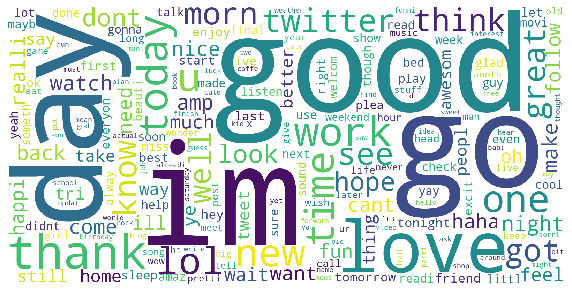

In [12]:
data_pos = df[df['Target'] == 1]['Tweet']
plt.figure(figsize = (10,10))
wc = WordCloud(
    max_words = 200 , width = 1600 , height = 800,collocations=False, background_color='white'
).generate(" ".join(data_pos))
plt.imshow(wc)
plt.axis('off')
plt.show()

# Step-5: Split the Data 

##### Percentage of Training data: 85%
##### Percentage of Test Data: 15%

In [13]:
from sklearn.model_selection import train_test_split

X = df.Tweet
Y = df.Target

X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.15,random_state =0)

print(X.shape)
print(X_train.shape)
print(X_test.shape)

(40000,)
(34000,)
(6000,)


# Step-6: Feature Extraction

#### Vectorization is a process in feature extraction. The idea is to get some distinct features out of the text for the model to train on, by converting text to numerical vectors. There are several techniques such as Bag of Words, Term Frequency-Inverse Document Frequency (TF-IDF), and Word2Vec. For this project we are using TF-IDF vectorization technique.

### Term Frequency - Inverse Document Frequency [TF-IDF]

TF-IDF is a numerical statistic intended to reflect how important a word is to a document. This is also a frequency-based method (like in Bag of Words) but the most frequent word is not considered to be most important, i.e. this technique doesn't let a word to dominate based on its frequency.

This technique has 2 parts:

1. Term Frequency (TF): This normalizes the frequency score of a word in the document. This number is always <= 1, providing the frequency of a word in context of all the words in a document.
>     TF = Frequency of word in a document/ Total number of words in that document

2. Inverse Document Frequency:
   In this, Document Frequency is the proportion of the documents that contain a certain word.
>     Document Frequency (DF) = Documents containing word W / Total number of documents

   So, what's IDF?
   
>     Inverse Document Frequency (IDF) = log(Total number of documents/ Documents containing word W)

IDF is the reciprocal of the Document Frequency. The intuition is that the more common a word is across all documents, the lesser its importance is for the current document.

A logarithm is taken to dampen the effect of IDF in the final calculation.

#### TD-IDF Final Score:
>     TF-IDF final score = TF * IDF

TF-IDF incorporates the significance of a word. The higher the score, the more important the word is!

Note: In this project, we are using TF-IDF vectorizer from sklearn.feature_extraction library.

[Reference](https://neptune.ai/blog/vectorization-techniques-in-nlp-guide) 

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=6000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

No. of feature_words:  6000


In [15]:
#vectorizing the data
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(34000, 6000)
(6000, 6000)


# Step-7: Model Building

In [16]:
# A function to evaluate prediction
def evaluatePrediction(y_test, y_pred):
    
    accuracy = accuracy_score(y_test,y_pred)
    
    print('Accuracy: ' + str(accuracy)+'\n')
    
    print('Classification Report: ')
    print(classification_report(y_test, y_pred))
    
    confusionMatrix = confusion_matrix(y_test,y_pred)
    plt.figure()
    plt.title('Confusion Matrix')
    sns.heatmap(confusionMatrix,annot=True,fmt='',linewidths=0.5)
    plt.show()

    # receiver operating characteristic curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    
    # graph showing the performance of a classification model at all classification thresholds
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC CURVE')
    plt.legend(loc="lower right")
    plt.show()

<h1>Support Vector Machine - Support Vector Classifier</h1>

In [17]:
from sklearn.svm import SVC

clf=SVC()
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

Accuracy: 0.7588333333333334

Classification Report: 
              precision    recall  f1-score   support

           0       0.78      0.72      0.75      3003
           1       0.74      0.80      0.77      2997

    accuracy                           0.76      6000
   macro avg       0.76      0.76      0.76      6000
weighted avg       0.76      0.76      0.76      6000



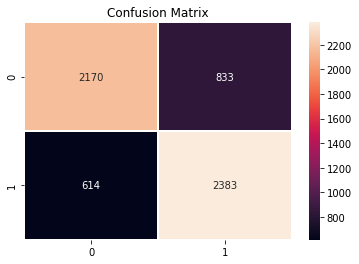

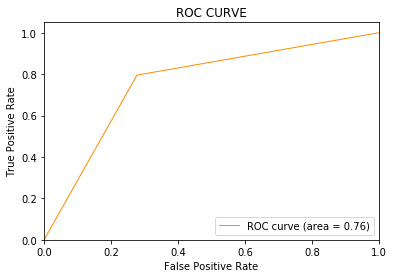

In [18]:
evaluatePrediction(y_test, y_pred)

<h1>eXtreme Gradient Boosting</h1>

Here, we sequentially train n decision trees sequentially, each attempting to correct the mistakes of the previous one.

In [19]:
from xgboost import XGBClassifier

xgbModel = XGBClassifier(max_depth=6, n_estimators=1000, use_label_encoder=False).fit(X_train, y_train)
y_pred = xgbModel.predict(X_test)

[16:19:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Accuracy: 0.744

Classification Report: 
              precision    recall  f1-score   support

           0       0.77      0.69      0.73      3003
           1       0.72      0.80      0.76      2997

    accuracy                           0.74      6000
   macro avg       0.75      0.74      0.74      6000
weighted avg       0.75      0.74      0.74      6000



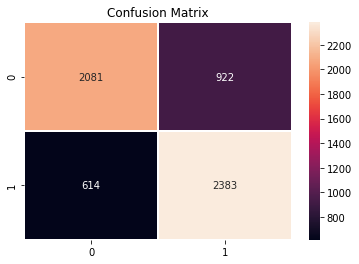

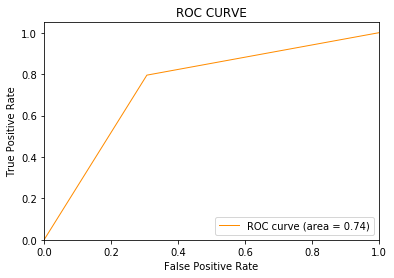

In [20]:
evaluatePrediction(y_test, y_pred)

<h1>Random Forest Classifier</h1>

Bagging with Decision Trees.

In [21]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 1000, criterion = 'entropy', max_depth=50)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

Accuracy: 0.724

Classification Report: 
              precision    recall  f1-score   support

           0       0.79      0.62      0.69      3003
           1       0.68      0.83      0.75      2997

    accuracy                           0.72      6000
   macro avg       0.73      0.72      0.72      6000
weighted avg       0.73      0.72      0.72      6000



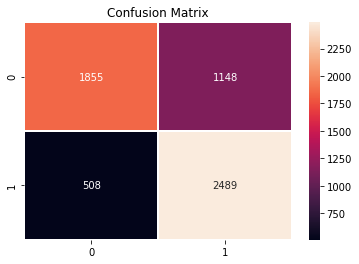

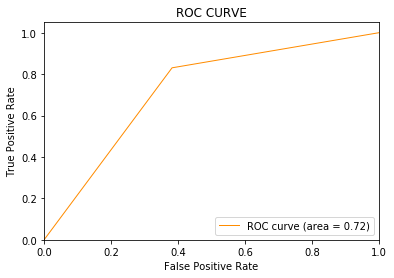

In [22]:
evaluatePrediction(y_test, y_pred)

<h1>Naive Bayes</h1>

In [23]:
from sklearn.naive_bayes import BernoulliNB

nb = BernoulliNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

Accuracy: 0.757

Classification Report: 
              precision    recall  f1-score   support

           0       0.78      0.72      0.75      3003
           1       0.74      0.80      0.77      2997

    accuracy                           0.76      6000
   macro avg       0.76      0.76      0.76      6000
weighted avg       0.76      0.76      0.76      6000



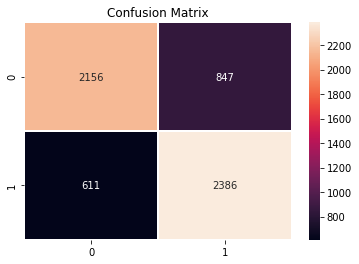

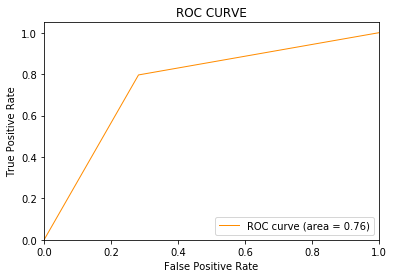

In [24]:
evaluatePrediction(y_test, y_pred)

<h1>Logistic Regression</h1>

In [25]:
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression()
lg.fit(X_train, y_train)
y_pred = lg.predict(X_test)

Accuracy: 0.7601666666666667

Classification Report: 
              precision    recall  f1-score   support

           0       0.78      0.73      0.75      3003
           1       0.74      0.79      0.77      2997

    accuracy                           0.76      6000
   macro avg       0.76      0.76      0.76      6000
weighted avg       0.76      0.76      0.76      6000



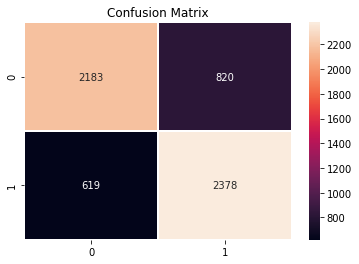

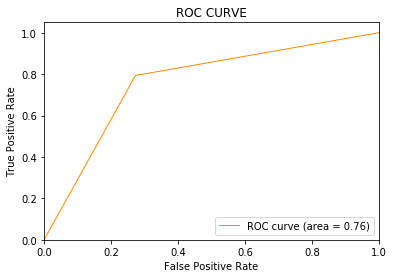

In [26]:
evaluatePrediction(y_test, y_pred)

# Decision Trees

In [27]:
from sklearn.tree import DecisionTreeClassifier
dc = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
dc.fit(X_train, y_train)
y_pred = dc.predict(X_test)

Accuracy: 0.6836666666666666

Classification Report: 
              precision    recall  f1-score   support

           0       0.69      0.67      0.68      3003
           1       0.68      0.70      0.69      2997

    accuracy                           0.68      6000
   macro avg       0.68      0.68      0.68      6000
weighted avg       0.68      0.68      0.68      6000



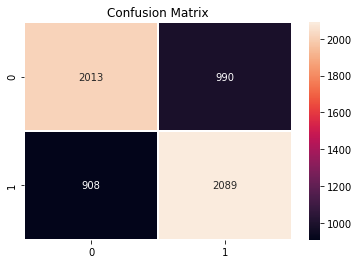

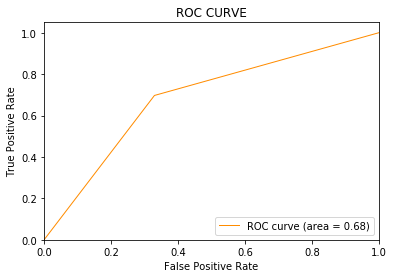

In [28]:
evaluatePrediction(y_test, y_pred)

# K-Nearest Neighbor (K-NN)

In [29]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 50, metric = "minkowski", p=2)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

Accuracy: 0.5455

Classification Report: 
              precision    recall  f1-score   support

           0       0.67      0.18      0.29      3003
           1       0.53      0.91      0.67      2997

    accuracy                           0.55      6000
   macro avg       0.60      0.55      0.48      6000
weighted avg       0.60      0.55      0.48      6000



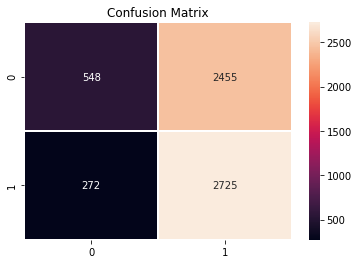

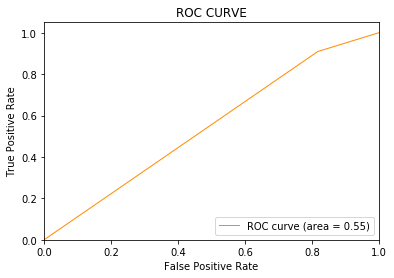

In [30]:
evaluatePrediction(y_test, y_pred)

# Recurrent neural networks (RNN)

In [31]:
import torchtext
import torch
import torch.nn as nn

glove = torchtext.vocab.GloVe(name="6B", dim = 50)

#### We store the index of each word in the pyTorch tensor instead of the while word, this choice causes efficient usage of memory.


In [32]:
# removes tweets without any words in the glove embeddings
#divides data into training, validation and testing parts
def splitAndProcessData(inp, glove=glove):
    
    train, test, valid = [], [], []
    
    i = 0
    
    for index, row in inp.iterrows():
        
        words = row['Tweet'].split()
        indices = []
        
        # keep indices of words that have embeddings in glove
        for word in words:
            if word in glove.stoi:
                # store index of the word in glove embeddings for memory efficiency
                indices.append(glove.stoi[word])
        
        # ignore tweets that do not have identified words in the glove embeddings
        if len(indices) == 0:
            continue
            
        # convert to pytorch tensor
        indices = torch.tensor(indices)
        
        label = torch.tensor(int(row['Target'] == 1)).long() # desired memory format
        
        if i % 5 < 3:
            train.append((indices, label))
        elif i % 5 == 3:
            valid.append((indices, label))
        else:
            test.append((indices, label))
        
        i += 1
        
    return train, test, valid

train, valid, test = splitAndProcessData(df)

Sample Training Set element

In [33]:
tweet, target = train[0]
print(tweet, target, sep='\n')

tensor([ 835, 6479, 1856, 1911,  254])
tensor(1)


#### Different shapes for input tensors

In [34]:
for i in range(10):
    tweet, label = train[i]
    print(tweet.shape)

torch.Size([5])
torch.Size([8])
torch.Size([10])
torch.Size([8])
torch.Size([3])
torch.Size([8])
torch.Size([11])
torch.Size([6])
torch.Size([5])
torch.Size([2])


<h3>Building a Model with pytorch's nn.Module</h3>

We use an nn.Embedding layer, instead of using the variable glove directly, because the nn.Embedding layer lets us look up the embeddings of multiple words simultaneously, so that our network can make predictions and train faster.

In [35]:
class RNNTweetClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNNTweetClassifier, self).__init__()
        
        self.embeddingLayer = nn.Embedding.from_pretrained(glove.vectors)
        
        self.hiddenSize = hidden_size
        
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        
        # Look up the embedding
        x = self.embeddingLayer(x)
        
        # Forward propagate the RNN
        out, _ = self.rnn(x)
        
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        
        return out

<h3>Batching</h3>
Approach 1: {Inefficient}<br>
Since each tweet has a different shaped tensor, we can not use the DataLoader with a batch size of greater than 1. We tackle this by padding shorter sequences with zeroes, so that every tensor is of the same length. We can use the following fuctions to achieve this:

. torch.nn.utils.rnn.pad_sequence<br>
. torch.nn.utils.rnn.pad_packed_sequence<br>
. torch.nn.utils.rnn.pack_sequence<br>
. torch.nn.utils.rnn.pack_padded_sequence<br>

Approach 2: {we do this}<br>
Padding all tweets with zeroes to make their length equal to the length of the longest tweet's tensor seems unreasonable. Hence, we work with mini-batches.

In [36]:
import random

class TweetBatcher:
    def __init__(self, inp, batch_size=32, drop_last=False):
        
        # store tweets by length
        self.tweetsByLength = {}
        
        for words, target in inp:

            wlen = len(words)
            
            if wlen in self.tweetsByLength:
                self.tweetsByLength[wlen].append((words, target))
            else:
                self.tweetsByLength[wlen] = [(words, target)]
            
        # create data loader for words same length
        self.loaders = dict()
        
        for wlen in self.tweetsByLength:
            self.loaders[wlen] = torch.utils.data.DataLoader(
                self.tweetsByLength[wlen]
                , batch_size=batch_size, 
                shuffle=True,
                drop_last=drop_last # remove last batch if smaller than batch size
            )
    
    def __iter__(self):
        
        iters = [iter(loader) for loader in self.loaders.values()]
        
        while iters:
            # pick a loader at random
            im = random.choice(iters)
            try:
                yield next(im)
            except StopIteration:
                iters.remove(im)

In [37]:
def trainRNN(model, train, valid, num_epochs=5, learning_rate=1e-5):
    
    criterion = nn.CrossEntropyLoss()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    losses, train_acc, valid_acc = [], [], []
    
    epochs = []
    
    for epoch in range(num_epochs):
        
        for tweet, target in train:
            
            optimizer.zero_grad()
            
            prediction = model(tweet)
            
            loss = criterion(prediction, target)
            
            loss.backward()
            
            optimizer.step()
            
        losses.append(float(loss))

        epochs.append(epoch)
        
        train_acc.append(get_accuracy(model, trainLoader))
        
        valid_acc.append(get_accuracy(model, validLoader))
        
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
              epoch + 1, loss, train_acc[-1], valid_acc[-1])
             )
    
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

In [38]:
def get_accuracy(model, data_loader):
    correct, total = 0, 0
    for tweets, labels in data_loader:
        output = model(tweets)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

Epoch 1; Loss 0.659250; Train Acc 0.546094; Val Acc 0.544095
Epoch 2; Loss 0.657211; Train Acc 0.587630; Val Acc 0.581602
Epoch 3; Loss 0.621570; Train Acc 0.621571; Val Acc 0.616320
Epoch 4; Loss 0.619619; Train Acc 0.640972; Val Acc 0.632539
Epoch 5; Loss 0.662781; Train Acc 0.646745; Val Acc 0.628104
Epoch 6; Loss 0.623725; Train Acc 0.652734; Val Acc 0.633680
Epoch 7; Loss 0.619433; Train Acc 0.653993; Val Acc 0.637481
Epoch 8; Loss 0.675371; Train Acc 0.655946; Val Acc 0.636974
Epoch 9; Loss 0.577459; Train Acc 0.656424; Val Acc 0.640522
Epoch 10; Loss 0.595885; Train Acc 0.658333; Val Acc 0.640395
Epoch 11; Loss 0.635612; Train Acc 0.661285; Val Acc 0.641029
Epoch 12; Loss 0.546696; Train Acc 0.659549; Val Acc 0.643183
Epoch 13; Loss 0.619248; Train Acc 0.663802; Val Acc 0.644830
Epoch 14; Loss 0.606090; Train Acc 0.664583; Val Acc 0.644957
Epoch 15; Loss 0.574454; Train Acc 0.664323; Val Acc 0.645337
Epoch 16; Loss 0.595224; Train Acc 0.667274; Val Acc 0.647491
Epoch 17; Loss 0.

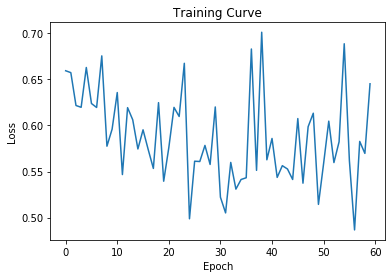

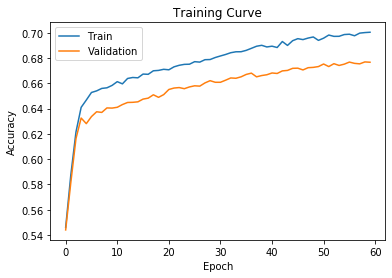

0.6743537759756716

In [39]:
model = RNNTweetClassifier(50, 10, 2)

trainLoader = TweetBatcher(train, batch_size=64, drop_last=True)
validLoader = TweetBatcher(valid, batch_size=64, drop_last=False)
testLoader = TweetBatcher(test, batch_size=64, drop_last=False)

trainRNN(model, trainLoader, validLoader, num_epochs=60, learning_rate=3e-4)

get_accuracy(model, testLoader)

<h3>BAGGING<h3>

In [40]:
# create bootstrap sample

def getBootstrapSample(df, sampleSize = 0.05):
    sizeOfDataFrame = df.shape[0]
    sampleSize = int(sampleSize * sizeOfDataFrame)
    return dfMain.iloc[np.random.randint(sizeOfDataFrame, size=sampleSize)]

In [41]:
# vectorize and split to test and train

vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=6000)

def preProcess(df):
    
    X = df.Tweet
    Y = df.Target

    X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.15,random_state =0)
    
    vectoriser.fit(X_train)
    
    X_train = vectoriser.transform(X_train)
    X_test  = vectoriser.transform(X_test)
    
    return X_train, X_test, y_train, y_test

In [42]:
# train a bag of models

def trainBag(n=20):
    
    bag = []
    
    model = BernoulliNB()
    
    for i in range(n):
        
        bs = getBootstrapSample(dfMain)

        X_train, X_test, y_train, y_test = preProcess(bs)

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test,y_pred)
            
        bag.append([model, acc])    
    
    return bag

In [43]:
bag = trainBag(10)
print(*bag, sep='\n')

[BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True), 0.7700833333333333]
[BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True), 0.7575]
[BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True), 0.76275]
[BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True), 0.7611666666666667]
[BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True), 0.7565]
[BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True), 0.7623333333333333]
[BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True), 0.76225]
[BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True), 0.76575]
[BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True), 0.7643333333333333]
[BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True), 0.7638333333333334]


Testing for accuracy of the bag

In [44]:
# create test sample
testSample = getBootstrapSample(dfMain, 0.1)
    
X = testSample.Tweet
Y = testSample.Target

X = vectoriser.transform(X)

Accuracy: 0.76049375

Classification Report: 
              precision    recall  f1-score   support

           0       0.77      0.74      0.76     80079
           1       0.75      0.78      0.76     79921

    accuracy                           0.76    160000
   macro avg       0.76      0.76      0.76    160000
weighted avg       0.76      0.76      0.76    160000



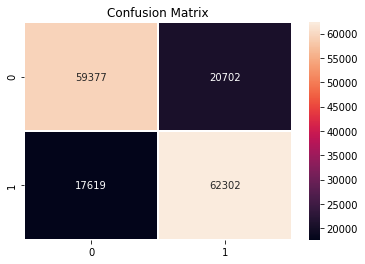

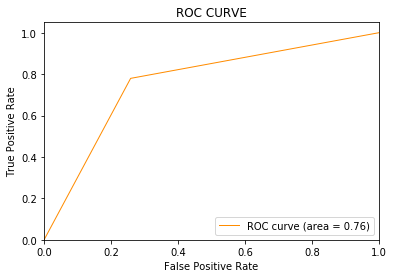

In [45]:
# find accuracy and stats.
y_pred = [0 for i in range(len(Y))]
weight_sum = 0

for model, weight in bag:
    
    y_pred_for_model = model.predict(X)
    
    for i in range(len(y_pred)):
        y_pred[i] += y_pred_for_model[i] * weight
    
    weight_sum += weight
    
y_pred = [pred / weight_sum for pred in y_pred]

y_pred = [round(pred) for pred in y_pred]
    
evaluatePrediction(Y, y_pred)